In [1]:
%cd ..
%ls 

from ch_est_net.preloading import *
from ch_est_net.Net import Net
from ch_est_net.criterion import MSE_detector_loss
from ch_est_net.Trainer import Trainer
import numpy as np

%load_ext autoreload
%autoreload 2

/home/alex/GitHub/ML_for_channel_estimation
ch_est_net/        lista_beam_net.pt  output.svg        torchvix-sample
config_beams.yaml  model_image        __pycache__/      torchvix-sample.png
config.yaml        model_image.png    README.md         zero.pt
data.h5            Notebooks/         requirements.txt
DMRS_signal/       one.pt             results/


In [2]:
cfg, dataL, dataS, device, deviceType, dtype, file, ml_default, onePilotFolder, path ,preload, print_function, scen0, Scenario = crazy_preloader()

Using CPU

Preload data: OK


In [3]:
def get_batch(snr_range, ind_range, seed):
    '''
    For files ind_range add noise with snr_range and stack all realizations to single array
    --------------------------------------------------------------------------
    RETURNS:
    pilot_batch -> [Realizations ; Antennas ; Subc ; Re/Im ]
    data_batch  -> [Realizations ; Antennas ; Subc ; 12? ; Re/Im]
    pilot_batch -> [Realizations]
    --------------------------------------------------------------------------
    Realizations = len(snr_range)*len(ind_range) 
    '''

    pilot_batch = torch.tensor(())
    data_batch = torch.tensor(())
    noise_P_batch = torch.tensor(())

    for snr in snr_range:
        for ind in ind_range:
            h_pilot, h_data = data_load(scen0, dtype = dtype, onePilotFolder = onePilotFolder,dataL=dataL, ind = ind)                                       # load data
            h_pilot, _ = add_noise(h_pilot, SNR = snr,scen=scen0, dtype=dtype, seed = seed)                             # add noise to pilots
            h_data_noisy, data_noise_power = add_noise_data(h_data, SNR = snr, dtype = dtype, seed = seed)     # add noise to data

            h_pilot = h_pilot.mean(dim = 2).unsqueeze(dim = 0)                                  # mean over pilots dim and add aditional dim
            h_data_noisy = h_data_noisy.unsqueeze(dim = 0)                                      # add additional dim for
            data_noise_power = data_noise_power.unsqueeze(dim =0)

            pilot_batch = torch.cat((pilot_batch, h_pilot), dim = 0)
            data_batch = torch.cat((data_batch, h_data_noisy), dim = 0)
            noise_P_batch = torch.cat((noise_P_batch, data_noise_power), dim = 0)

    return pilot_batch, data_batch, noise_P_batch

In [4]:
u_batch, data_batch, noise_batch = get_batch(snr_range = [-12, -8, -6 , -3 ,0],
                                              ind_range = range(1, 140, 3),
                                              seed = 3)

In [6]:
import torch
from ch_est_net.activation import sigmoid
from torch import nn
from ch_est_net.utils import DFT_matrixes, MM

class Net_Layer(torch.nn.Module):

    def __init__(self, cfg, freq_samples, time_samples, Trainable=True, isPass=False):
        super(Net_Layer, self).__init__()

        self.S1 = torch.nn.Parameter(
            torch.tensor([cfg.S1]), requires_grad = False)
        self.S2 = torch.nn.Parameter(
            torch.tensor([cfg.S2]), requires_grad = False)

        self.DFT_re, self.DFT_im, self.IDFT_re, self.IDFT_im = DFT_matrixes(
            freq_samples, time_samples, True)

        self.isPass = isPass
        self.cfg = cfg
        self.recived = cfg.recived

    def setTrainable(self, value: bool):
        if value == True:
            self.S1.requires_grad = True
            self.S2.requires_grad = True

        else:
            self.S1.requires_grad = False
            self.S1.grad = None
            self.S2.requires_grad = False
            self.S2.grad = None

    def forward(self, u_re, u_im, z_re, z_im, H_hat_re, H_hat_im):
        if self.isPass == False:

            Z_re, Z_im = MM(z_re, z_im, self.IDFT_re, self.IDFT_im)

            R_re = H_hat_re + Z_re
            R_im = H_hat_im + Z_im

            R_mean = torch.sqrt(torch.mean((R_re**2 + R_im**2), dim=0))

            H_hat_mean = sigmoid(R_mean, self.S1, self.S2, self.recived)

            H_hat_re = R_re * H_hat_mean
            H_hat_im = R_im * H_hat_mean

            h_hat_re, h_hat_im = MM(
                H_hat_re, H_hat_im, self.DFT_re, self.DFT_im)

            z_re = u_re - h_hat_re
            z_im = u_im - h_hat_im

        return z_re, z_im, H_hat_re, H_hat_im



In [7]:
class Net(torch.nn.Module):
    def __init__(self, cfg):
        super(Net, self).__init__()

        self.network = nn.ModuleList(
            [Net_Layer(cfg, 48, 512) for i in range(cfg.layers)])

        print("Created Net with ", cfg.layers, "layers")

        self.DFT_re, self.DFT_im = DFT_matrixes(48, 512)
        self.recived = cfg.recived

    def forward(self, u):
        H_hat_re = torch.zeros([self.recived, 512])
        H_hat_im = torch.zeros([self.recived, 512])

        u, maximum = self.normalize(u)

        u_re = u[:, :, 0]
        u_im = u[:, :, 1]

        z_re = u_re
        z_im = u_im

        for layer in self.network:
            z_re, z_im, H_hat_re, H_hat_im = layer(
                u_re, u_im, z_re, z_im, H_hat_re, H_hat_im)

        h_hat_re, h_hat_im = MM(H_hat_re, H_hat_im, self.DFT_re, self.DFT_im)

        out = torch.stack((h_hat_re, h_hat_im), dim=2)

        out = self.denormalize(out, maximum)
        return out

    def normalize(self, u):
        maximum = abs(u.max())
        u = 5*u/maximum
        return u, maximum

    def denormalize(self, u, maximum):
        u = u/5*maximum
        return u

    def setState(self, trainable_code, pass_code):

        c = [bool(int(d)) for d in str(trainable_code)]
        p = [bool(int(d)) for d in str(pass_code)]

        for i, module in enumerate(self.network):
            module.setTrainable(c[i])
            module.isPass = p[i]


In [38]:
import numpy as np 

class Trainer():
    def __init__(self, net, cfg, optimizer, criterion):
        self.net = net
        self.cfg = cfg
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = cfg.epochs

        self.scenary = self.gen_scenary(cfg.layers)
        self.pass_scenary = self.gen_pass_scenary(cfg.layers)

        self.loss_history = []
    

    def train_with_scenary(self, u, h_data_noisy, data_noise_power, scen0):
        for i in range(0, len(self.scenary)):
            print('\n', 'Stage ', i)
            self.net.setState(self.scenary[i], self.pass_scenary[i])
            self.train(tr_round = i, u = u, h_data_noisy= h_data_noisy, data_noise_power = data_noise_power, scen0= scen0, epochs = self.epochs)


    def allow_all(self):
        scenary = self.gen_scenary(self.cfg.layers)[-1]
        pass_scenary = self.gen_pass_scenary(self.cfg.layers)[-1]
        self.net.setState(scenary, pass_scenary)
    

    def train_with_scenary_batch(self, u_batch, h_data_batch, noise_power_batch, scen0):
        for i in range(0, len(self.scenary)):
            print('\n', 'Stage ', i)
            self.net.setState(self.scenary[i], self.pass_scenary[i])
            self.batch_train(u_batch= u_batch, h_data_batch= h_data_batch, noise_power_batch = noise_power_batch, scen0= scen0, epochs = self.epochs)


    def batch_train(self, u_batch , h_data_batch, noise_power_batch, scen0, epochs):
        loss_history = []
        degrade_counter = 0
        flat_counter = 0
        prev_loss = 0 

        for i in range(epochs):
            batch_loss = torch.tensor([0.0], requires_grad = True)

            for sample in range(u_batch.shape[0]):
                h_rec = self.net.forward(u_batch[sample,:,:,:])
                loss_value = self.criterion(h_rec, h_data_batch[sample,:,:,:,:], noise_power_batch[sample], scen0)
                batch_loss = batch_loss + loss_value
            
            self.optimizer.zero_grad()
            batch_loss.backward(retain_graph = True)
            self.optimizer.step()

            if prev_loss < batch_loss: degrade_counter+=1 
            elif torch.isclose(prev_loss, batch_loss, atol=1e-03): flat_counter+=1
            else: 
                degrade_counter-=1
                flat_counter-=1

            if degrade_counter > 2:
                break
            
            if flat_counter > 2:
                break
            
            prev_loss = batch_loss
            

            if i%1 ==0: print('epoch = ',i,', loss = ',np.round(batch_loss.item(), 6))
            loss_history.append(batch_loss.item())

        return loss_history


    def train(self, u , tr_round, h_data_noisy, data_noise_power, scen0, epochs):
        degrade_counter = 0
        flat_counter = 0

        prev_loss = 0
        for i in range(epochs):
            # зануляем градиент
            self.optimizer.zero_grad()
            
            #прогоняем через сетку
            h_rec = self.net.forward(u)

            loss_value = self.criterion(h_rec, h_data_noisy, data_noise_power, scen0) 
            #MSE_detector_loss(h_rec)

            if i%5 ==0: 
                self.loss_history.append(loss_value)
                print('round = ',tr_round,', loss = ',np.round(loss_value.item(), 6))

            loss_value.backward(retain_graph=True)
            
            self.optimizer.step()

            if prev_loss < loss_value: degrade_counter+=1 
            elif torch.isclose(prev_loss, loss_value, atol=1e-06): flat_counter+=1
            else: 
                degrade_counter-=1
                flat_counter-=1


            #for p in lamp.parameters():
            #    p.data.clamp_(min = 0.00001, max = 500)
            

            if degrade_counter > 3:
                break
            
            if flat_counter > 50:
                break
            
            prev_loss = loss_value
            
        
    def bin_to_dec(self, bin_str):
        if type(bin_str == str):
            return  int(bin_str , 2) 
        return -1


    def dec_to_bin(self, dec_val):
        return bin(dec_val)[2:]


    def gen_scenary(self, n_layers):
        n_zeros = n_layers - 1
        start_value = '1'
        end_value = '1'

        start_value += '0' * n_zeros
        end_value += '1' * n_zeros

        scenary = []

        current_dec = self.bin_to_dec(start_value)
        scenary.append(start_value)

        first_dec = self.bin_to_dec(start_value)
        second_dec = first_dec

        for i in range(1, n_layers):
            first = i*'0' + self.dec_to_bin(int(first_dec/2))
            scenary.append(first)
            first_dec = self.bin_to_dec(first)

            second_dec = second_dec + first_dec
            second = self.dec_to_bin(second_dec)
            scenary.append(second)

        return scenary


    def gen_pass_scenary(self, n_layers):
        start = '0' + '1'*(n_layers-1)
        pass_scen = []

        pass_scen.append(start)
        start_dec = self.bin_to_dec(start)

        current = start_dec
        for i in range(1, n_layers-1):
            
            start = (i+1)*'0' + self.dec_to_bin(start_dec >> 1)

            pass_scen.append(start)
            pass_scen.append(start)

            start_dec = self.bin_to_dec(start)

        end = '0' * n_layers
        pass_scen.append(end)
        pass_scen.append(end)
        return pass_scen


In [26]:
with open('config.yaml') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
cfg = Namespace(**dict(cfg))

net = Net(cfg)
optimizer = torch.optim.Adam(net.parameters() , lr = 1.0e-1 )

criterion = MSE_detector_loss
trainer = Trainer(net, cfg, optimizer, criterion)
trainer.train_with_scenary_batch(u_batch, data_batch, noise_batch, scen0)


Created Net with  8 layers

 Stage  0
epoch =  0 , loss =  148.658356
epoch =  1 , loss =  138.170044
epoch =  2 , loss =  127.96666
epoch =  3 , loss =  118.089951
epoch =  4 , loss =  108.698677
epoch =  5 , loss =  99.917374
epoch =  6 , loss =  91.796539
epoch =  7 , loss =  84.349472
epoch =  8 , loss =  77.583427
epoch =  9 , loss =  71.503418
epoch =  10 , loss =  66.105293
epoch =  11 , loss =  61.372616
epoch =  12 , loss =  57.27578
epoch =  13 , loss =  53.770943
epoch =  14 , loss =  50.800793
epoch =  15 , loss =  48.298397
epoch =  16 , loss =  46.193573
epoch =  17 , loss =  44.419479
epoch =  18 , loss =  42.916912
epoch =  19 , loss =  41.636265
epoch =  20 , loss =  40.537334
epoch =  21 , loss =  39.588234
epoch =  22 , loss =  38.763767
epoch =  23 , loss =  38.044083
epoch =  24 , loss =  37.413086
epoch =  25 , loss =  36.85783
epoch =  26 , loss =  36.3675
epoch =  27 , loss =  35.933121
epoch =  28 , loss =  35.547028
epoch =  29 , loss =  35.202778
epoch =  30 

KeyboardInterrupt: 

In [39]:
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.98)
criterion = MSE_detector_loss
trainer = Trainer(net, cfg, optimizer, criterion)
trainer.train_with_scenary_batch(u_batch, data_batch, noise_batch, scen0)



 Stage  0
epoch =  0 , loss =  32.001026
epoch =  1 , loss =  31.980539
epoch =  2 , loss =  31.942005
epoch =  3 , loss =  31.889481
epoch =  4 , loss =  31.82799
epoch =  5 , loss =  31.762686
epoch =  6 , loss =  31.698303
epoch =  7 , loss =  31.638786
epoch =  8 , loss =  31.586906
epoch =  9 , loss =  31.544334
epoch =  10 , loss =  31.511723
epoch =  11 , loss =  31.489006
epoch =  12 , loss =  31.475491
epoch =  13 , loss =  31.470215
epoch =  14 , loss =  31.471989
epoch =  15 , loss =  31.479643
epoch =  16 , loss =  31.491978
epoch =  17 , loss =  31.507923
epoch =  18 , loss =  31.526522
epoch =  19 , loss =  31.54689
epoch =  20 , loss =  31.568304
epoch =  21 , loss =  31.590117
epoch =  22 , loss =  31.611732
epoch =  23 , loss =  31.632687
epoch =  24 , loss =  31.652575
epoch =  25 , loss =  31.671045
epoch =  26 , loss =  31.687771
epoch =  27 , loss =  31.702572

 Stage  1
epoch =  0 , loss =  28.675465
epoch =  1 , loss =  28.673668
epoch =  2 , loss =  28.670176
e

KeyboardInterrupt: 

In [35]:

'''Функция предсказания. Прогоняет данные для всех указанных SNR и файлов'''
def preds( net, dtype, onePilotFolder,dataL, ml = ml_default, 
            lossVersion='detector', # 'detector' or 'relError'
            inds=range(1,141), 
            SNR_L=range(-10,-1), 
            seed=4, 
            max_iter=3, 
            ml_version=12, 
            SNRscaleFactor=1.,
            scen=scen0, scale=True):
    assert lossVersion in ['detector', 'relError']
    N_used = scen.RB_num*scen.RB_size
    loss = []
    comb = scen.comb

    z = torch.zeros(64, 512, 2, requires_grad = False)
    h_hat = torch.zeros(64, 512, 2, requires_grad = False) 

    losses = []

    if lossVersion == 'detector':
        N_pilot_sym = scen.N_pilot*scen.N_TTI
        N_data_sym = (14-N_pilot_sym)*scen.N_TTI;
        for SNR in SNR_L:
            loss_current = 0
            for ind in inds:
                h_pilot, h_data = data_load(scen, dtype = dtype, onePilotFolder = onePilotFolder,dataL = dataL, ind = ind+1 ,use_preloaded = False)
                h_pilot_noisy, _ = add_noise(h_pilot, SNR, scen=scen0, dtype=dtype, seed=seed)
                h_data_noisy, data_noise_power = add_noise_data(h_data, SNR,dtype= dtype, seed=seed) 

                u = h_pilot_noisy.mean(dim=2)

                # CHANNEL ESTIMATION # оценка канала 
                #preds = NET.forward(u = u)
                h_pilot_rec = net.forward(u=u)
                
                # Show time domain recovered and initial signals
                if ind % 70==-1:
                    h_pilot_rec_numpy = upsampling(scen, h_pilot_rec, inverse=False).detach().numpy()
                    plt.plot(h_pilot_rec_numpy[0,:,0]**2+h_pilot_rec_numpy[0,:,1]**2)
                    h_f = h_pilot
                    if len(h_f.shape) == 4:
                        h_f = h_f.mean(dim=2)
                    h_f = upsampling(scen, h_f, inverse=False).detach().numpy()
                    plt.plot(h_f[0,:,0]**2+h_f[0,:,1]**2)
                    plt.show()            
                assert h_pilot_rec.shape[1] == N_used
                H_re = h_pilot_rec[:, :, 0]
                H_im = -h_pilot_rec[:, :, 1]
                
                # Detector error calculation
                err_data = 0
                for k in range (N_data_sym):    
                    det_data = torch.zeros((N_used, 2))   
                    assert h_data_noisy.shape[1] == N_used 
                    Y = h_data_noisy[:, :, k, :]                    
                    det_data[:,0] = (torch.sum(Y[:,:,0]*H_re-Y[:,:,1]*H_im, dim=0)/
                                    (data_noise_power+torch.sum(H_re**2+H_im**2, dim=0)))
                    det_data[:,1] = (torch.sum(Y[:,:,1]*H_re+Y[:,:,0]*H_im, dim=0)/
                                    (data_noise_power+torch.sum(H_re**2+H_im**2, dim=0)))
                      
                    err = det_data - torch.Tensor([1.,0.])  
                    err_data = err_data+torch.sum(err**2)
    
                loss_current += err_data/(N_data_sym*N_used)

                cur = {'loss': err_data.detach().numpy() ,'SNR': SNR, 'file': ind}
                losses.append(cur)

            loss.append(loss_current)        
            
    return loss, losses

In [36]:
# Вызов функции
SNR_range = range(-12,1,3)
scenario_range = range(1, 140, 2)

detector_error_beam_net_1, losses = preds(net= net, 
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            SNR_L=SNR_range)


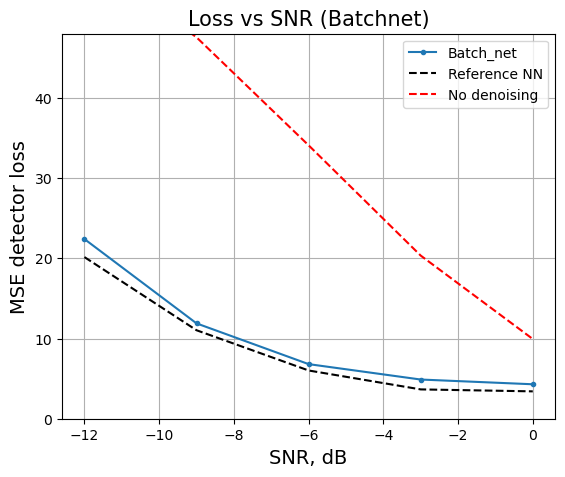

In [37]:
reference = [20.1498, 11.0312,6.0139, 3.6551, 3.4109 ]
noise = [57.8161, 47.5496, 34.0860, 20.339, 9.9376]



plt.style.use("default")

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(SNR_range,detector_error_beam_net_1,'.-' ,label = 'Batch_net')
plt.plot(SNR_range,reference,'--k',label = 'Reference NN' )
plt.plot(SNR_range,noise,'--r',label = 'No denoising' )

plt.legend()
plt.title("Loss vs SNR (Batchnet)", fontsize = 15)
plt.xlabel("SNR, dB" , fontsize = 14)
plt.ylabel("MSE detector loss", fontsize = 14);
plt.ylim([0 , 48])
plt.grid()

